In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
sys.path.append('..')

In [7]:
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian

## _(A.) Visualize Test Data_

Inspect easy to difficult to reconstruct tracks. Choose 10 such events and use `score_cut=0.25`

In [8]:
inputdir="run/feature_store/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [9]:
feature_data = torch.load(proc_files[0], map_location=device)

In [10]:
feature_data.event_file[-4:]

'5000'

In [11]:
event_id = int(os.path.basename(feature_data.event_file)[-4:])

In [12]:
event_id

5000

## _(B.) Inspection on Track Duplication_

- lets plot two reconstructed events, one is `clean` and the other a little `complex`
- see an event with duplicated tracks, find out why they are duplicated.

In [13]:
# get list of true tracks (test dataset)
inputdir="run/gnn_evaluation/test"
true_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

In [14]:
# get list of reco tracks (test dataset)
inputdir="run/trkx_from_gnn"
reco_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

### _(1.) - Plot True Event (Clean)_

In [15]:
# The Good Event
event_idx = 15

In [16]:
# true events
true_event = torch.load(true_trkx[event_idx], map_location=device)

In [17]:
true_event.event_file[-4:]

'5015'

In [18]:
np.unique(true_event.pid)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [19]:
# hit features
r, phi, ir = true_event.x.T

In [20]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [21]:
# compensate scaling
ir = ir.detach().numpy()*100

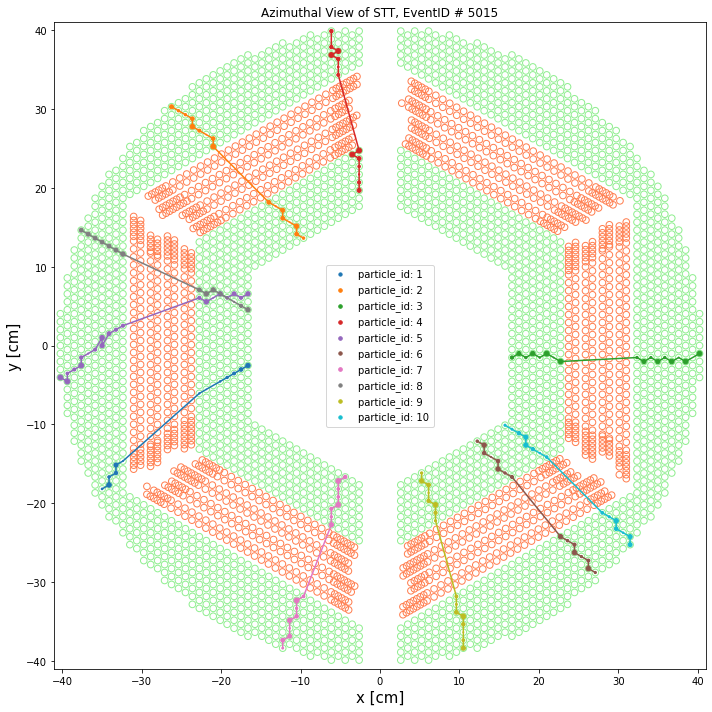

In [22]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_event.event_file[-4:])
p_ids = np.unique(true_event.pid)

for pid in p_ids:
    idx = true_event.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
fig.savefig("clean_true.png")

### _(2.) - Plot Reco Event (Clean)_

In [23]:
# lets plot reconstructed true event, i.e. event = 96
reco_event = torch.load(reco_trkx[event_idx], map_location=device)

In [24]:
reco_event.head()

,hit_id,track_id
0,177,0
1,203,1
2,228,2
3,24,3
4,48,4


Now, we've only the `hit_id` and `track_id`, what are corresponding spatial coordinates (x,y coordinates)? How about using `hit_id` to filter features from the true event?

Note, the `hit_id`, `track_id` in reco data are equiv. to `hid`, `pid` in true data.

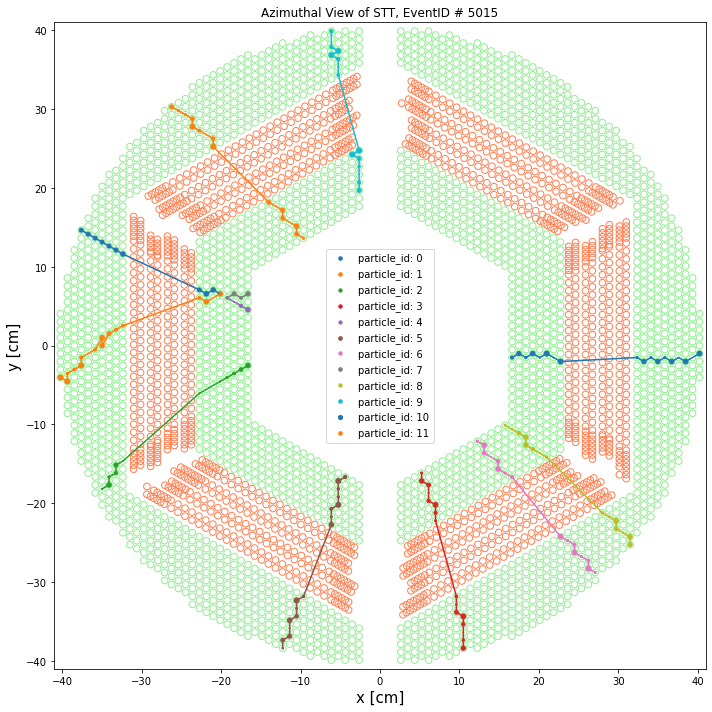

In [25]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_event.track_id)
for tid in t_ids:
    idx = reco_event.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
fig.savefig("clean_reco.png")

In [26]:
!./eval_reco_evt.sh $e_id

Out of 5002 events processing 1 events with 1 workers
Output directory: /home/adeak977/current/3_deeptrkx/ctd2022/eval/run/trkx_reco_eval
Running 5015


In [27]:
with open("run/trkx_reco_eval/{}_summary.txt".format(e_id)) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
Run Time:      20220617-172547
Reconstructed tracks: /home/adeak977/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   11
Reco. tracks matched:                   11
Reco. tracks matched to POI:                   11
Reco. tracks duplicated:                    1
Tracking Eff.:             100.0000%
Fake rate:                   0.0000%
Duplication Rate:               9.0909%
--------------------------------------------------
Run Time:      20220617-180426
Reconstructed tracks: /home/adeak977/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   12
Reco. tracks matched:                   12
Reco. tracks matched to POI:                   12
Reco. tracks duplicated:                    2
Tracking Eff.:

### _(3.) - Plot True Event (Complex)_

In [28]:
# The Good Event
event_idx = 51

In [29]:
# true events
true_event = torch.load(true_trkx[event_idx], map_location=device)

In [30]:
true_event.event_file[-4:]

'5051'

In [31]:
np.unique(true_event.pid)

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [32]:
# hit features
r, phi, ir = true_event.x.T

In [33]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [34]:
# compensate scaling
ir = ir.detach().numpy()*100

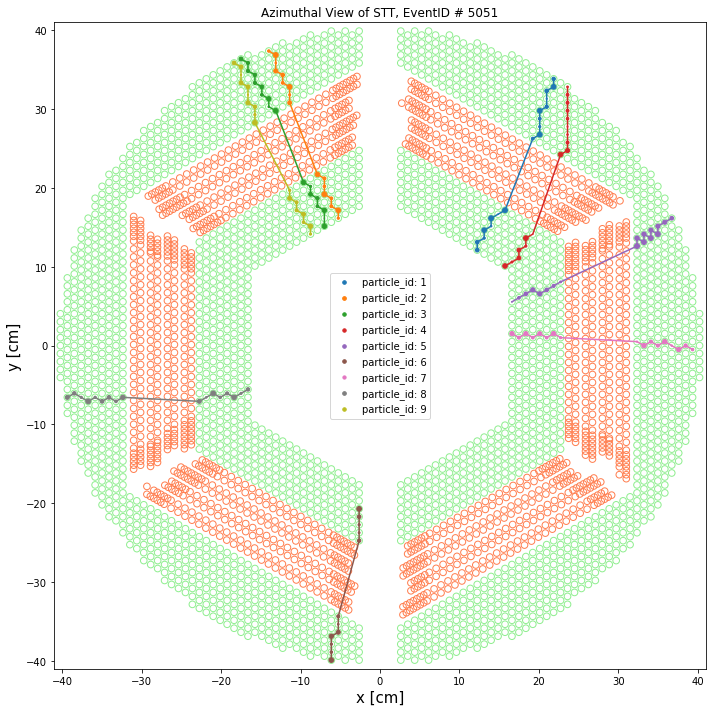

In [35]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_event.event_file[-4:])
p_ids = np.unique(true_event.pid)

for pid in p_ids:
    idx = true_event.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("{}_complex_true.png".format(e_id))

### _(4.) - Plot Reco Event (Complex)_

In [36]:
# lets plot reconstructed true event, i.e. event = 96
reco_event = torch.load(reco_trkx[event_idx], map_location=device)

In [37]:
reco_event.head()

,hit_id,track_id
0,1,0
1,52,1
2,148,2
3,174,3
4,199,4


Now, we've only the `hit_id` and `track_id`, what are corresponding spatial coordinates (x,y coordinates)? How about using `hit_id` to filter features from the true event?

Note, the `hit_id`, `track_id` in reco data are equiv. to `hid`, `pid` in true data.

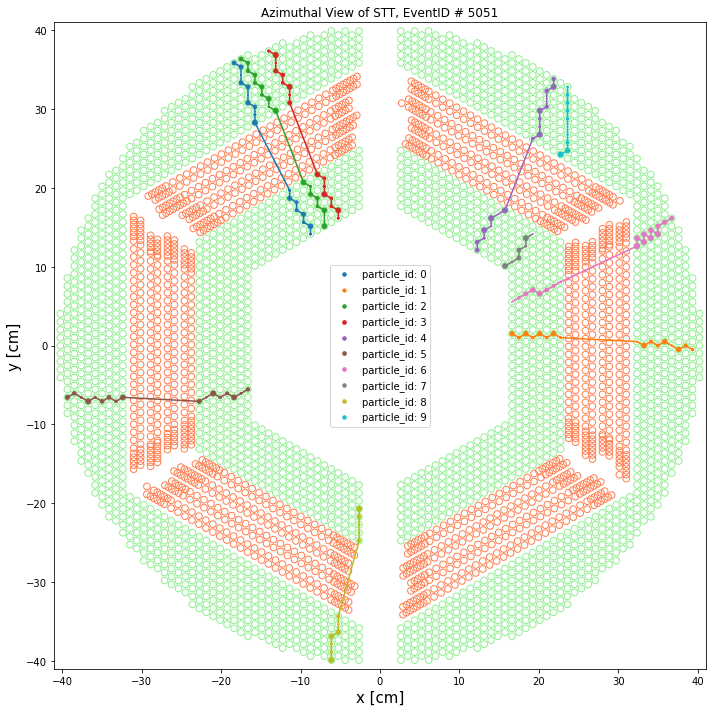

In [38]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_event.track_id)
for tid in t_ids:
    idx = reco_event.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("{}_complex_reco.png".format(e_id))

In [39]:
!./eval_reco_evt.sh $e_id

Out of 5002 events processing 1 events with 1 workers
Output directory: /home/adeak977/current/3_deeptrkx/ctd2022/eval/run/trkx_reco_eval
Running 5051


In [40]:
with open("run/trkx_reco_eval/{}_summary.txt".format(e_id)) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
Run Time:      20220617-180527
Reconstructed tracks: /home/adeak977/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                    9
Truth tracks matched:                    9
Reco. tracks:                   10
Reco. tracks matched:                   10
Reco. tracks matched to POI:                   10
Reco. tracks duplicated:                    1
Tracking Eff.:             100.0000%
Fake rate:                   0.0000%
Duplication Rate:              10.0000%



## _Unassigned Hits_

What is _`track_id=-1`_ contains?

The _hits_ not assigned to any track are collected under `track_id=-1`.

In [41]:
dup_hids = reco_event.query("track_id==-1")["hit_id"]

In [42]:
dup_hids.values

array([], dtype=int32)